# Real estate price prediction using linear regression

### Implementation from scratch

Libraries used(scikit-learn imported for later use, the algorithm is implemented with custom functions and preprocessing at first and only then I moved on to production-like implementation with sklearn)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

###### Load the data set
From the below displayed fraction of a given real estate prices dataset it's easy to notice that some of the given features would cause noise in the sense that they would lead the model astray. Transaction date, house number and coordinates are excessive data so they're going to be removed from the dataset. If we're just using raw lat/long information we should remove them because the values of lat/long are not meaningful in and of themselves, conditional on your model not having any "understanding" of what a change in lat/long means. For instance, what would a change in 1 degree in latitude mean in terms of a change in your target variable? If there is nothing related that way, then you introduce either noise or potentially spurious relationships. The reason for house number and transaction date being taken out of the dataset is trivial.

In [2]:
df = pd.read_csv('Real estate.csv')
df.head(10)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.417,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.417,17.9,1783.18000,3,24.96731,121.51486,22.1


###### Cleaning data

In [3]:
# setting No as the index to avoid redundancy
df.set_index('No' , inplace = True)
# removing excess columns
del df['X1 transaction date'] , df['X5 latitude'] , df['X6 longitude']
df.head(10)

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,Y house price of unit area
No,,,,
1,32.0,84.87882,10,37.9
2,19.5,306.59470,9,42.2
3,13.3,561.98450,5,47.3
4,13.3,561.98450,5,54.8
5,5.0,390.56840,5,43.1
6,7.1,2175.03000,3,32.1
7,34.5,623.47310,7,40.3
8,20.3,287.60250,6,46.7
9,31.7,5512.03800,1,18.8


After the dataset has been cleaned we can shift our attention to normalizing the features.

In [4]:
# loading in the dataset into numpy ndarray
data = np.loadtxt('Real estate.csv' , delimiter = ',' , skiprows = 1)
# cleaning the array just like the corresponding pd DataFrame above
data = np.delete(data , [0 , 1 , 5 , 6] , 1)

In [5]:
data[:10]

array([[3.200000e+01, 8.487882e+01, 1.000000e+01, 3.790000e+01],
       [1.950000e+01, 3.065947e+02, 9.000000e+00, 4.220000e+01],
       [1.330000e+01, 5.619845e+02, 5.000000e+00, 4.730000e+01],
       [1.330000e+01, 5.619845e+02, 5.000000e+00, 5.480000e+01],
       [5.000000e+00, 3.905684e+02, 5.000000e+00, 4.310000e+01],
       [7.100000e+00, 2.175030e+03, 3.000000e+00, 3.210000e+01],
       [3.450000e+01, 6.234731e+02, 7.000000e+00, 4.030000e+01],
       [2.030000e+01, 2.876025e+02, 6.000000e+00, 4.670000e+01],
       [3.170000e+01, 5.512038e+03, 1.000000e+00, 1.880000e+01],
       [1.790000e+01, 1.783180e+03, 3.000000e+00, 2.210000e+01]])

In [11]:
# design matrix
X_train = data[: , :3]
# label matrix
y_train = data[: , 3]

###### Normalization

In [12]:
def normalize(X):
    """
    Normalize features
    Args:
      X (ndarray (m,n)): Feture matrix (design matrix), m examples with n features
    Returns:
      Normalized feature matrix
    """
    mu = np.mean(X , axis = 0)
    stdev = np.std(X , axis = 0)
    return (X - mu) / stdev

def normalize_vector(X , x):
    """
    Normalizes single vector
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      x (ndarray (n,)): Feature vector
    Returns:
      z-score normalized feature vector
    """
    mu = np.mean(X)
    stdev = np.std(X)
    return (x - mu) / stdev

In [13]:
# normalized design matrix
X_norm = normalize(X_train)
print(f'Peek to peek before normalization: {np.ptp(X_train , axis = 0)}')
print(f'Peek to peek after normalization: {np.ptp(X_norm , axis = 0)}')

Peek to peek before normalization: [  43.8     6464.63816   10.     ]
Peek to peek after normalization: [3.84929156 5.12828671 3.39904571]


###### Computing cost

In [14]:
def compute_cost(X , y , w , b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      Cost
    """
    m = X.shape[0]
    return sum((np.dot(X , w) + b - y) ** 2) / (2 * m)

Computing cost eith zero-initialized w and b parameters

In [15]:
w_in = np.zeros(3)
b_in = 0
compute_cost(X_norm , y_train , w_in , b_in)

813.5921980676324

###### Computing gradient for given w and b parameters

In [16]:
def compute_gradient(X , y , w , b):
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m , n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0.
    err = np.dot(X , w) + b - y
    for i in range(m):
        for j in range(n):
            dj_dw[j] += err[i] * X[i , j]
        dj_db += err[i]
    dj_dw /= m
    dj_db /= m
    
    return dj_dw , dj_db

In [17]:
tmp_dj_dw, tmp_dj_db = compute_gradient(X_norm , y_train , w_in , b_in)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -37.98019323671498
dj_dw at initial w,b: 
 [ 2.86161559  9.15442889 -7.75998233]


###### Gradient descent for finding global minima of the cost function (finding optimal w, b parameters)

In [18]:
def gradient_descent(X , y , w , b , alpha , num_iters , gradient_function , cost_function):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w (ndarray (n,)      : initial model parameters  
      b (scalar)          : initial model parameter
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      gradient_function   : function to compute the gradient
      cost_function       : function to compute cost
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    J_history = []
    for i in range(num_iters):
        dj_dw , dj_db = gradient_function(X , y , w , b)
        
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Save cost J at each iteration
        if i < 100000:      # prevent resource exhaustion 
            J_history.append(cost_function(X, y, w, b))
            
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % np.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history # return final w,b and J history for graphing

In [23]:
# initialize parameters
initial_w = np.zeros_like(w_in)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 1.0e-1
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_norm , y_train , initial_w , initial_b ,
                                                    alpha , iterations , 
                                                    compute_gradient , compute_cost)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")

Iteration    0: Cost   662.52   
Iteration  100: Cost    42.38   
Iteration  200: Cost    42.38   
Iteration  300: Cost    42.38   
Iteration  400: Cost    42.38   
Iteration  500: Cost    42.38   
Iteration  600: Cost    42.38   
Iteration  700: Cost    42.38   
Iteration  800: Cost    42.38   
Iteration  900: Cost    42.38   
b,w found by gradient descent: 37.98,[-2.87717494 -6.78084682  3.81707864] 


###### Making predictions

In [24]:
def predict(X , w , b):
    """
    prediction using linear regression
    Args:
      X (ndarray): Shape (m,n) / (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      prediction (scalar) / (ndarray (n,))
    """
    return np.dot(X , w) + b

In [25]:
X_pred = predict(X_norm , w_final , b_final)
x_custom = np.array([20. , 300. , 9.])

# normalizing the feature vector
x_custom_norm = normalize_vector(X_train , x_custom)
# making predictions with normalized vector
x_pred = predict(x_custom_norm , w_final , b_final)

print(f'Predictions: {X_pred[:3]}\nTarget variables: {y_train[:3]}')
print(f'Prediction with custom features: {x_custom}: {x_pred}')

Predictions: [47.40375034 48.07436724 43.07852862]
Target variables: [37.9 42.2 47.3]
Prediction with custom features: [ 20. 300.   9.]: 38.087734008185755


###### Plotting the learning curve

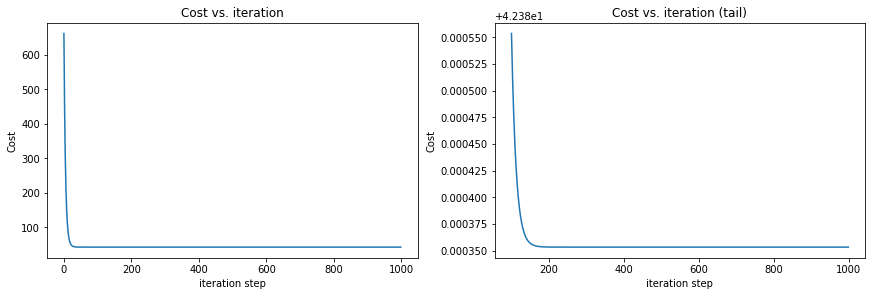

In [26]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

### Implementation with sklearn

###### Scale/normalize the training data

In [29]:
scaler = StandardScaler()
sk_X_norm = scaler.fit_transform(X_train)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis = 0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(sk_X_norm,axis = 0)}")

Peak to Peak range by column in Raw        X:[  43.8     6464.63816   10.     ]
Peak to Peak range by column in Normalized X:[3.84929156 5.12828671 3.39904571]


###### Create and fit the regression model

In [30]:
sgdr = SGDRegressor(max_iter = 1000)
sgdr.fit(sk_X_norm , y_train)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

number of iterations completed: 25, number of weight updates: 10351.0


###### View parameters

In [31]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:\nw: {w_norm}, b:{b_norm}")

model parameters:
w: [-2.87075113 -6.7809304   3.853759  ], b:[38.0059003]


###### Computing cost with newly found parameters

In [32]:
compute_cost(sk_X_norm , y_train , w_norm , b_norm)

42.38139051731808

###### Make predictions

In [33]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(sk_X_norm)
# make a prediction using w,b. 
y_pred = np.dot(sk_X_norm, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:3]}" )
print(f"Target values \n{y_train[:3]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[47.51122199 48.16229954 43.11307251]
Target values 
[37.9 42.2 47.3]


###### Plot Results

In [34]:
# feature vector
X_features = ['X2 house age','X3 distance to the MRT','X4 number of convenience stores']

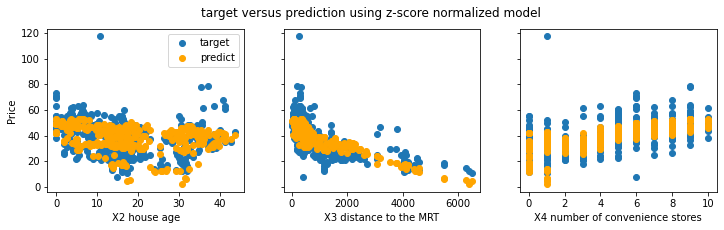

In [35]:
# plot predictions and targets vs original features    
fig,ax = plt.subplots(1,3,figsize = (12,3),sharey = True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],y_pred,color = 'orange', label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()